## Resources:

- [Documentation for MLHub API and dataset](https://radiant-mlhub.s3-us-west-2.amazonaws.com/landcovernet/Documentation.pdf): Here is all the information about labels, dataset structure, etc.
- [Tutorial with notebooks for MLHub](https://github.com/radiantearth/mlhub-tutorials/blob/master/notebooks/radiant-mlhub-landcovernet.ipynb)

In [ ]:
%%capture
!pip -q install rasterio
!pip install fastai --upgrade

In [ ]:
import rasterio as rio
from rasterio.plot import show
from matplotlib import pyplot as plt
import numpy
from fastai.vision.all import *
import matplotlib.patches as mpatches

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Export labels in color to filter out manually

In [ ]:
!unzip 'landcovernet_RGB.zip'

Streaming output truncated to the last 5000 lines.
  inflating: landcovernet/35NLA_25/35NLA_25_20180104_B02_10m.tif  
  inflating: landcovernet/35NLA_25/35NLA_25_2018_LC_10m.tif  
   creating: landcovernet/34KEV_08/
  inflating: landcovernet/34KEV_08/34KEV_08_20180101_B02_10m.tif  
  inflating: landcovernet/34KEV_08/34KEV_08_2018_LC_10m.tif  
  inflating: landcovernet/34KEV_08/34KEV_08_20180101_B03_10m.tif  
  inflating: landcovernet/34KEV_08/34KEV_08_20180101_B04_10m.tif  
  inflating: landcovernet/34KEV_08/34KEV_08_20180101_B08_10m.tif  
   creating: landcovernet/33LUD_18/
  inflating: landcovernet/33LUD_18/33LUD_18_20180103_B08_10m.tif  
  inflating: landcovernet/33LUD_18/33LUD_18_20180103_B04_10m.tif  
  inflating: landcovernet/33LUD_18/33LUD_18_20180103_B02_10m.tif  
  inflating: landcovernet/33LUD_18/33LUD_18_2018_LC_10m.tif  
  inflating: landcovernet/33LUD_18/33LUD_18_20180103_B03_10m.tif  
   creating: landcovernet/31NFH_06/
  inflating: landcovernet/31NFH_06/31NFH_06_20180101

In [ ]:
def get_rgb(path_dict) :
  red = rio.open(path_dict['red']).read(1) # B4
  green = rio.open(path_dict['green']).read(1) # B3
  blue = rio.open(path_dict['blue']).read(1) # B2

  rgb = np.dstack((red, green, blue))

  # normalize and convert to range 0-255
  rgb = ((rgb - rgb.min()) / (rgb.max() - rgb.min()) * 255).astype(int)
  return rgb

In [ ]:
def get_labels(path):
  labels = rio.open(path).read(1) # LC_10m.tif file
  return labels

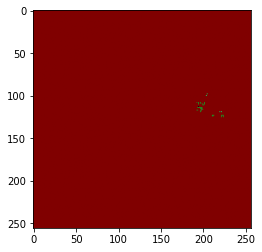

In [ ]:
labels = {0:'Unknown', 1:'Water', 2:'Artificial soil', 3:'Natural soil', 4:'Snow/Ice', 5:'Woody vegetation', 6:'Cultivated vegetation', 7:'Natural vegetation'}
colors = {0:'k', 1:'b', 2:'gray', 3:'maroon', 4:'whitesmoke', 5:'forestgreen', 6:'orange', 7:'springgreen'}
patches = [ mpatches.Patch(color=colors[i], label=f'{labels[i]}') for i in range(len(labels)) ]

Path('labels').mkdir(parents=True, exist_ok=True)

for loc in Path('landcovernet').ls() :
  for img in loc.ls() :
    if re.search('.*_LC_10m.tif', str(img)) : path = img
  filename = str(path).split('/')[-1].split('.')[0]
  #print(filename)
  im = np.array([[matplotlib.colors.to_rgb(colors[i]) for i in j] for j in get_labels(path)])
  plt.imsave('labels/' + filename + '.png', im)

In [ ]:
%%capture
!zip -r labels.zip labels

Now, I manually deleted labels where the annotation was badly performed. With 1980 labels, it took me around 30 minutes. Unfortunately, I had to discard over 50% of the labels. I saved the filtered labels as labels.zip again.

# Load filtered labels and delete images that have no labels

First of all, I uploaded the archive with filtered labels into Colab.

In [ ]:
!unzip labels.zip

Archive:  labels.zip
   creating: labels/
   creating: labels/labels_full/
   creating: labels/labels_full/.ipynb_checkpoints/
  inflating: labels/labels_full/28QDE_00_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_01_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_02_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_03_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_04_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_05_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_06_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_07_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_08_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_09_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_10_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_11_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_12_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_13_2018_LC_10m.png  
  inflating: labels/labels_full/28QDE_14_2018_L

In [ ]:
paths = Path('labels').ls()
locs = [re.findall(r'(.*)_2018_LC_10m.png', str(path).split('/')[-1]) for path in paths]
locs = list(itertools.chain(*locs))
len(locs)

920

Remove RGB images that have **no label** because we deleted it due to bad quality

In [ ]:
for img in Path('landcovernet_RGB/inputs').ls() :
  imname = re.findall(r'(.*_[0-9]+)_2018[0-9]+_RGB.png', str(img).split('/')[-1])[0]
  if not imname in locs : 
    os.remove(img)

In [ ]:
%%capture
!zip -r landcovernet_RGB_hq_labels.zip landcovernet_RGB

# Remove cloudy images that bypassed the first assessment

Next step: Even though theoretically, we should have clean data by now, there are still images with clouds present in the training data. This is because the "non-cloudy" images were simply *estimated* as such, but it cannot be guaranteed. To remove cloudy images, I have to go through them manually and simply delete from the dataset.

Finally, I saved the completely prepared and clean data as `landcovernet_final.zip`

This is the archive that we will use in the training.